In [3]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time

In [4]:
import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

In [5]:
rod_length = 0.09982061776030171
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('new_kitty_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.033273539253433904 0.0023291477477403733


In [6]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.01
dsw = 0.01

In [7]:
# import pickle 
# import gzip
# pickle.dump(curved_linkage, gzip.open('{}_no_feature_joints_20201209.pkl.gz'.format(io.MODEL_NAME), 'w'))

In [8]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [9]:
set_surface_view_options(curved_linkage_view, surface_transparent = True)

In [10]:
double_view = get_double_side_view(curved_linkage, flip = True)

In [11]:
# double_view.show()

In [12]:
double_view.getCameraParams()

((0.0, 0.0, 5.0), (0.0, 1.0, 0.0), (0.0, 0.0, 0.0))

In [23]:
curved_linkage.setExtendedDoFsPSRL(np.load('../../../mega_monster_optimization_diagram_results/new_kitty_1/new_kitty_1_stage_2.npy', allow_pickle = True)[-1]['extendedDoFsPSRL'])
# curved_linkage.setExtendedDoFsPSRL(np.load('results/new_kitty_1/new_kitty_1_dof.npy'))
# curved_linkage.setExtendedDoFsPSRL(np.load('results/new_kitty_1_no_feature_joints/new_kitty_1_no_feature_joints_dof.npy'))

In [17]:
# get_all_curve_pattern(curved_linkage, min(io.RIBBON_CS), io.SUBDIVISION_RESOLUTION, io.RIBBON_NAME, 'svg', target_ribbon_width = 5, flip_angles = True, select_ribbon_index = [5])

In [18]:
curved_linkage.attraction_weight = 0.1

In [19]:
# curved_linkage.energy(elastic_rods.SurfaceAttractionEnergyType.Elastic)

In [20]:
# curved_linkage.energy(elastic_rods.SurfaceAttractionEnergyType.Attraction)

In [21]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [22]:
iterateData, dpo = stage_1_optimization(curved_linkage, drw, dsw, curved_linkage_view, E0 = E0, l0 = l0)

In [23]:
# curved_linkage.scaleJointWeights(0.1, 100, [214, 255, 39])

In [24]:
# jointPos = curved_linkage.jointPositions()
# jointPos = jointPos.reshape((curved_linkage.numJoints(), 3))
# scaled_jointPos = jointPos[np.array([214, 255, 39])]
# with open('{}_feature_joint_pos.obj'.format(io.MODEL_NAME), 'w') as f:
#     for pt in scaled_jointPos:
#         pt *= 100
#         f.write('v {} {} {}\n'.format(pt[0], pt[1], pt[2]))

In [24]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [25]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00027548	0.657083	0.657083	1	1
1	5.56431e-05	0.0202796	0.0202796	1	1
2	4.40855e-05	0.00467791	0.00467791	1	1
3	3.77509e-05	0.0020088	0.0020088	1	1
4	3.37723e-05	0.000997902	0.000997902	1	0
5	2.97353e-05	0.00806983	0.00806983	1	1
6	2.96604e-05	9.30205e-05	9.30205e-05	1	0
7	2.96274e-05	0.000182028	0.000182028	1	0
8	2.96268e-05	1.18661e-05	1.18661e-05	1	0
9	2.96268e-05	1.63898e-07	1.63898e-07	1	0


In [29]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [23]:
# optimizer.scaleJointWeights(0.6, 100, [214, 255, 39])

In [24]:
optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -1, 2, maxIter = 35)

rl_regularization_weight 0.9999999999999999
smoothing_weight 10.0
stage 2 optimization with attraction weight 100.0
stage 2 optimization with attraction weight 0.1


In [ ]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
set_surface_view_options(validation_curved_view)
validation_curved_view.show()

In [ ]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [ ]:
set_joint_vector_field(validation_curved_linkage, validation_curved_view, deviation_vector)

Min Width  0.033273539253433904
Scale:  150.26955689674608
num seg per rod 40
num seg per rod 40
num seg per rod 264
num seg per rod 40
num seg per rod 40
num seg per rod 88
num seg per rod 88
num seg per rod 40
num seg per rod 40
num seg per rod 94
num seg per rod 40
num seg per rod 84
num seg per rod 94
num seg per rod 40
30.053911379349216


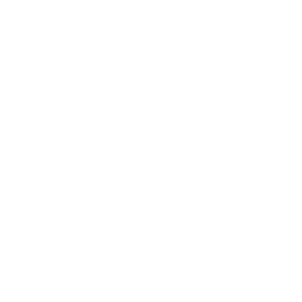

In [25]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_no_feature_joints', io.RIBBON_NAME + '_no_feature_joints', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
os.chdir(save_path)

Coefficient of Friction Percentiles 50, 75, 90:  1.0401996096520982 3.1830219435226823 7.331164355828557


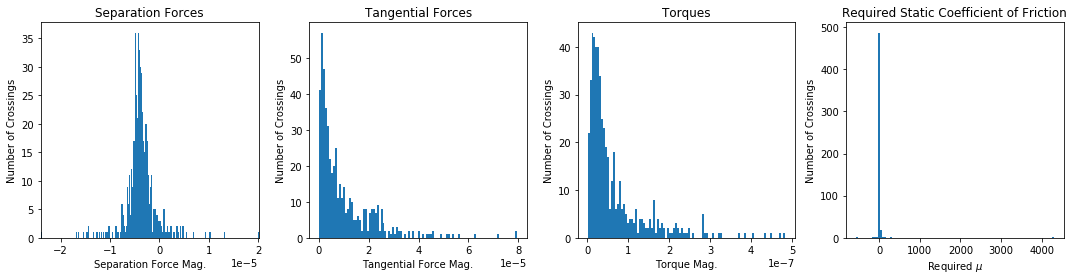

In [27]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [58]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
    curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)

In [ ]:
optimizer.scaleJointWeights(0.1, 1000, [396, 412, 497])
# contact_optimization(optimizer, curved_linkage_view, -1, contact_weight = 1e4)
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-5)

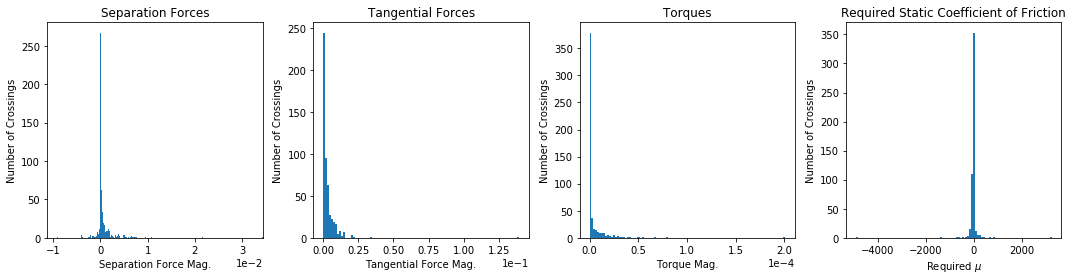

In [67]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [52]:
import pickle
import gzip
pickle.dump(curved_linkage, gzip.open('{}_contact_opt_by_flipping_2020_1209.pkl.gz'.format(io.MODEL_NAME), 'w'))